# *Desafio 

Integrantes: \
                 -Hugo Rocha -- 201610531-K \
                 -Gabriel Vergara -- 201510519-7

Equipo: RNG

In [152]:
import warnings
warnings.filterwarnings("ignore")

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.decomposition import PCA
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import KFold

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [154]:
df_train = pd.read_csv("ferramenta_competition_train.csv")
df_test = pd.read_csv("ferramenta_competition_test_without_labels.csv")

# -Exploratorio

_@staffa_squadretta_      285
_@cerniera_bandella_      274
_@vernice_                252
_@morsetto_strettoio_     206
_@spazzola_               190
_@pinzetta_               176
_@accessori_saldatore_    147
_@collare_                144
_@pennello_               144
_@chiodo_rivetto_         139
_@spatola_raschietto_     108
_@coltello_               106
_@bancale_cargo_          102
_@chiavistello_            93
_@cazzuola_frattone_       82
_@estrattore_              76
Name: class, dtype: int64


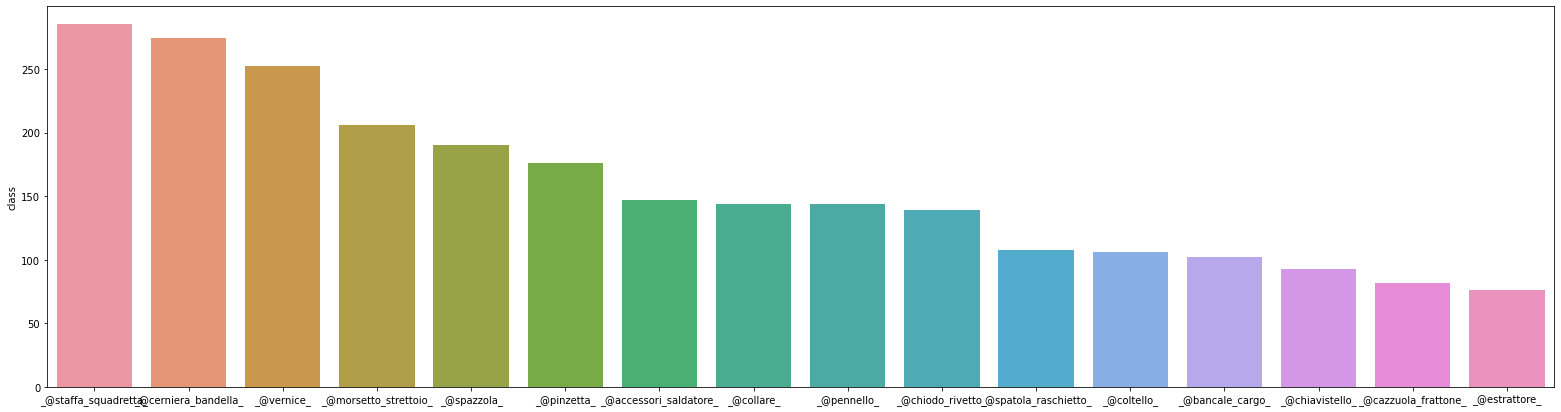

In [155]:
fig, ax = plt.subplots(figsize=(27, 7))
x=df_train['class'].value_counts()
print(x)
sns.barplot(x.index,x)
plt.show()

A continuacion trabajaremos solo con el texto

In [156]:
df_train['word_count_title'] = df_train['title'].apply(lambda x: len(str(x).split()))
df_train['word_count_description'] = df_train['description'].apply(lambda x: len(str(x).split()))
for i in df_train['class'].unique():
    print('Para la clase',i,'la cantidad de palabras promedio del titulo son ',df_train[df_train['class']==i]['word_count_title'].mean(),' y para la descripcion son  ',df_train[df_train['class']==i]['word_count_description'].mean()) 

Para la clase _@morsetto_strettoio_ la cantidad de palabras promedio del titulo son  9.072815533980583  y para la descripcion son   19.776699029126213
Para la clase _@vernice_ la cantidad de palabras promedio del titulo son  9.253968253968255  y para la descripcion son   24.66269841269841
Para la clase _@cerniera_bandella_ la cantidad de palabras promedio del titulo son  12.930656934306569  y para la descripcion son   17.233576642335766
Para la clase _@staffa_squadretta_ la cantidad de palabras promedio del titulo son  12.442105263157895  y para la descripcion son   18.32982456140351
Para la clase _@accessori_saldatore_ la cantidad de palabras promedio del titulo son  9.45578231292517  y para la descripcion son   17.904761904761905
Para la clase _@coltello_ la cantidad de palabras promedio del titulo son  8.773584905660377  y para la descripcion son   14.358490566037736
Para la clase _@collare_ la cantidad de palabras promedio del titulo son  9.041666666666666  y para la descripcion so

Ahora podemos ver la distribucion de la cantidad de palabra por descripcion y titulo

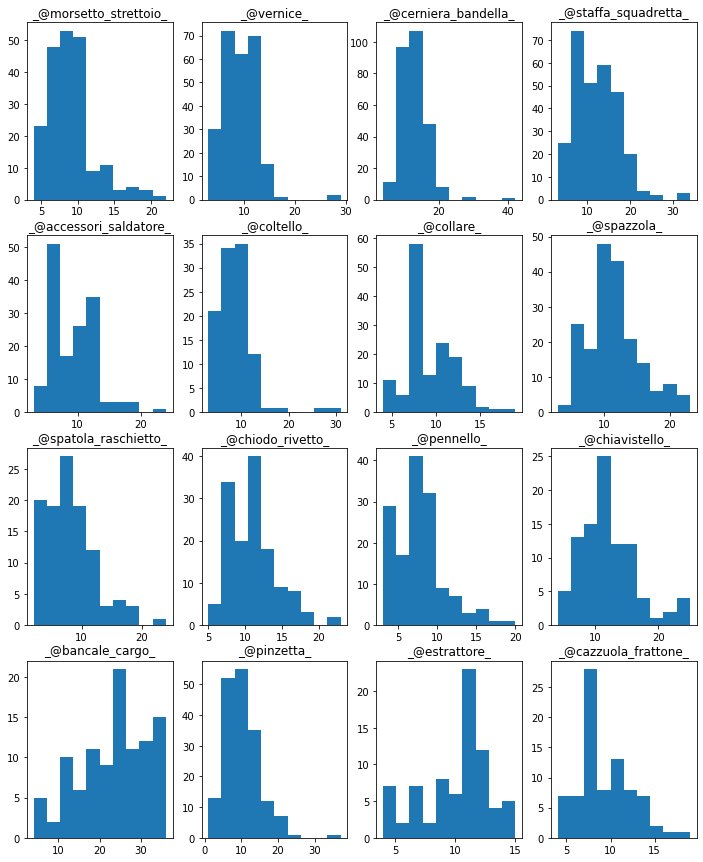

In [157]:
fig, ax = plt.subplots(figsize=(12, 15))
j=1
for i in df_train['class'].unique():
    plt.subplot(4, 4, j)
    plt.hist(df_train[df_train['class']==i]['word_count_title'])
    plt.title(i)
 
    j+=1


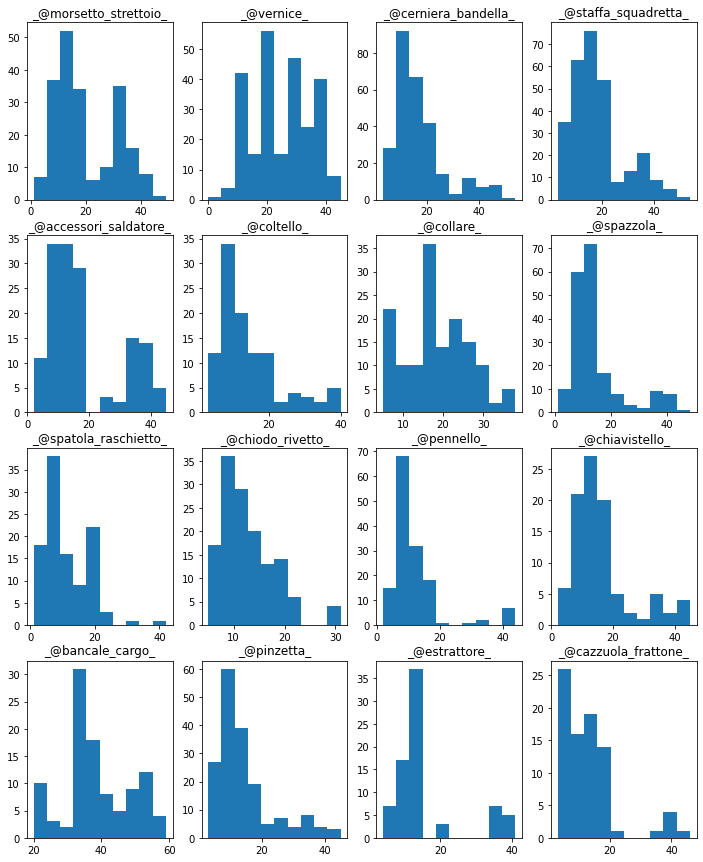

In [158]:
fig, ax = plt.subplots(figsize=(12, 15))
j=1
for i in df_train['class'].unique():
    plt.subplot(4, 4, j)
    plt.hist(df_train[df_train['class']==i]['word_count_description'])
    plt.title(i)
 
    j+=1

# -Preprocesamiento 

A continuacion se emplean algunas funciones que nos permiten limpiar los textos de elementos que no brindan informacion relevante para la clasificacion.

In [159]:
def preprocess(text): # Funcion que elimina caracteres basura
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

In [160]:
# Funcion que se deshace de conectores que tal vez brindan contexto pero que estorban con el enfoque que se le busca dar al modelo
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('italian')]
    return ' '.join(a)

In [161]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [162]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

A continuacion le damos el tratamiento correspondiente tanto a nuestros datos de texto.

In [163]:
df_train['clean_title'] = df_train['title'].apply(lambda x: finalpreprocess(x))
df_train['clean_description'] = df_train['description'].apply(lambda x: finalpreprocess(x))

In [164]:
df_test['clean_title'] = df_test['title'].apply(lambda x: finalpreprocess(x))
df_test['clean_description'] = df_test['description'].apply(lambda x: finalpreprocess(x))
df_test=df_test.drop(['title','description'],axis=1)

In [165]:
X=df_train.drop(['class','title','description','image'],axis=1)
y=df_train["class"].ravel()

In [166]:
#Separamos la data
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=42,stratify=y)

In [167]:
X_train_number=X_train.drop(['clean_title','clean_description','word_count_title','word_count_description'],axis=1)
df_test_number=df_test.drop(['clean_title','clean_description','image'],axis=1)

In [168]:
X_val_number=X_val.drop(['clean_title','clean_description','word_count_title','word_count_description'],axis=1)

## -Vectorizacion de textos

En este caso trabajaremos vectorizando el titulo

In [169]:
count_vect = CountVectorizer(ngram_range=(1,1)) # por defeccto n-grama=1
X_train_counts = count_vect.fit_transform(X_train['clean_title'])

In [170]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf_T = tfidf_transformer.fit_transform(X_train_counts).toarray()

In [171]:
X_val_counts = count_vect.transform(X_val['clean_title'])
X_val_tfidf_T = tfidf_transformer.transform(X_val_counts).toarray()

In [172]:
X_test_counts = count_vect.transform(df_test['clean_title'])
X_test_tfidf_T = tfidf_transformer.transform(X_test_counts).toarray()

Ahora vectorizaremos la descripcion

In [173]:
count_vect = CountVectorizer(ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(X_train['clean_description'])

In [174]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf_D = tfidf_transformer.fit_transform(X_train_counts).toarray()

In [175]:
X_val_counts = count_vect.transform(X_val['clean_description'])
X_val_tfidf_D = tfidf_transformer.transform(X_val_counts).toarray()

In [176]:
X_test_counts = count_vect.transform(df_test['clean_description'])
X_test_tfidf_D = tfidf_transformer.transform(X_test_counts).toarray()

Finalmente concatenamos la informacion de los texto vectorizados con la infromacion numerica de las filas F, a partir de este punto es posible juntar 

In [177]:
#X_train_final=np.concatenate((X_train_tfidf,np.array(X_train_number)),axis=1)
X_train_final=np.concatenate((X_train_tfidf_D,X_train_tfidf_T,np.array(X_train_number)),axis=1)


In [178]:
#X_val_final=np.concatenate((X_val_tfidf,np.array(X_val_number)),axis=1)
X_val_final=np.concatenate((X_val_tfidf_D,X_val_tfidf_T,np.array(X_val_number)),axis=1)

In [179]:
#X_test_final=np.concatenate((X_test_tfidf,np.array(df_test_number)),axis=1)
#X_test_final=np.concatenate((X_test_tfidf_D,X_test_tfidf_T,np.array(df_test_number)),axis=1)

# -Prueba de modelos

A continuacion pondremos a prueba algunos modelos de clasificacion para poder indentificar, cual es el mas apropiado para la tarea en cuestion.

## -Clasificador Logistico (el mejor hasta ahora)

### -Mixto

In [180]:
logistic_reg = LogisticRegression(solver='liblinear')
logistic_reg.fit(X_train_final,y_train)

LogisticRegression(solver='liblinear')

In [181]:
y_pred=logistic_reg.predict(X_val_final)

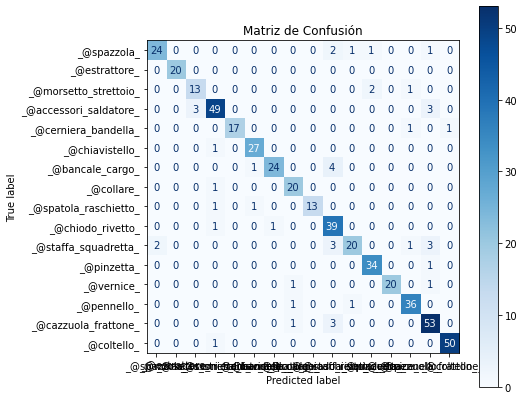

In [182]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [183]:
f1_score(y_val,y_pred,average='macro')

0.9086157835814823

### -Solo Texto

In [184]:
X_train_text=np.concatenate((X_train_tfidf_D,X_train_tfidf_T),axis=1)
X_val_text=np.concatenate((X_val_tfidf_D,X_val_tfidf_T),axis=1)

In [185]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_text,y_train)

LogisticRegression()

In [186]:
y_pred=logistic_reg.predict(X_val_text)

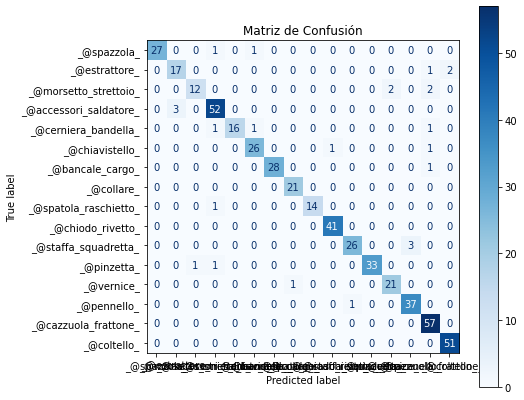

In [187]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [188]:
f1_score(y_val,y_pred,average='macro')

0.9403947220417512

### -Solo Numericas

In [189]:
pca = PCA(n_components=250)
pca.fit(X_train_number)

PCA(n_components=250)

In [190]:
X_train_number_pca=pca.transform(X_train_number)
X_val_number_pca=pca.transform(X_val_number)

In [191]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_number_pca,y_train)

LogisticRegression()

In [192]:
y_pred=logistic_reg.predict(X_val_number_pca)

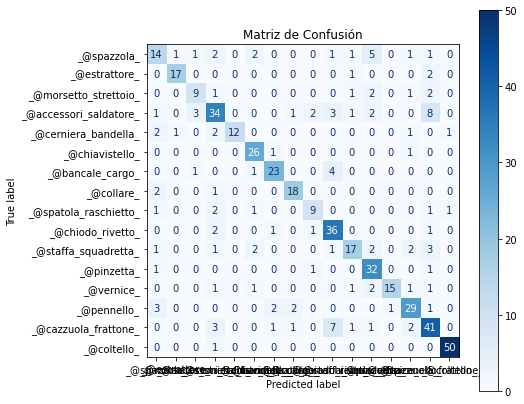

In [193]:
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [194]:
f1_score(y_val,y_pred,average='macro')

0.7489008216491226

## -Bayes Ingenuo multinomial

### -Mixto

In [195]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_final,y_train)

In [196]:
y_pred=clf.predict(X_val_final)

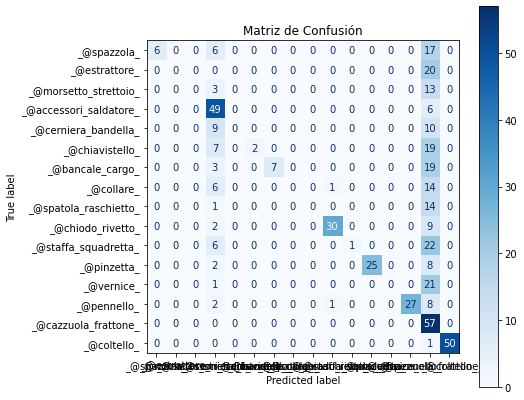

In [197]:
cm = confusion_matrix(y_val,y_pred)
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [198]:
f1_score(y_val,y_pred,average='macro')

0.3384066886236743

### -Solo texto 

In [199]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_D,y_train)

In [200]:
y_pred=clf.predict(X_val_tfidf_D)

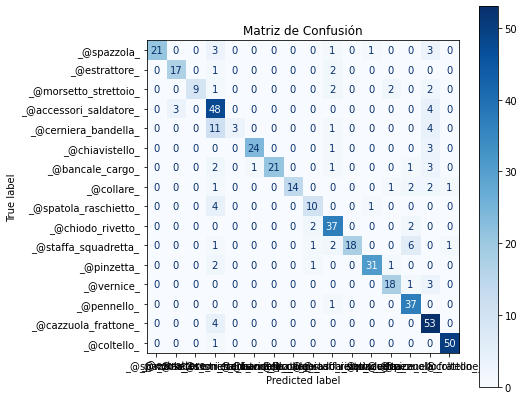

In [201]:
# Matriz de confusion
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [202]:
f1_score(y_val,y_pred,average='macro')

0.7858949158217594

### -Solo Numericas

In [203]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_number,y_train)

In [204]:
y_pred=clf.predict(X_val_number)

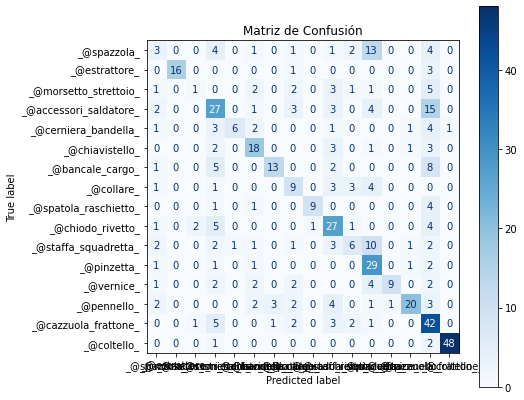

In [205]:
# Matriz de confusion
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [206]:
f1_score(y_val,y_pred,average='macro')

0.5290553831550264

## -QDA

### -Mixto

In [207]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train_final,y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [208]:
y_pred=qda.predict(X_val_final)

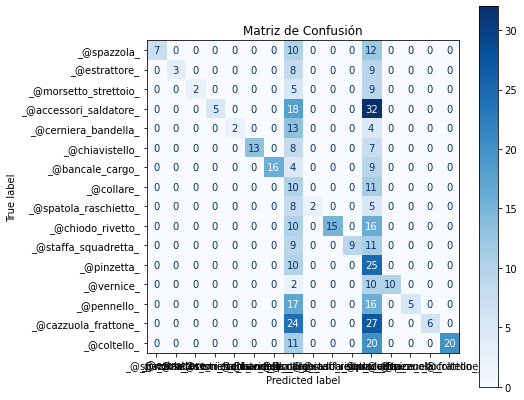

In [209]:
# Matriz de confusion
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [210]:
f1_score(y_val,y_pred,average='macro')

0.3581668524981605

### -Solo Texto

In [211]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train_tfidf_D,y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [212]:
y_pred=qda.predict(X_val_tfidf_D)

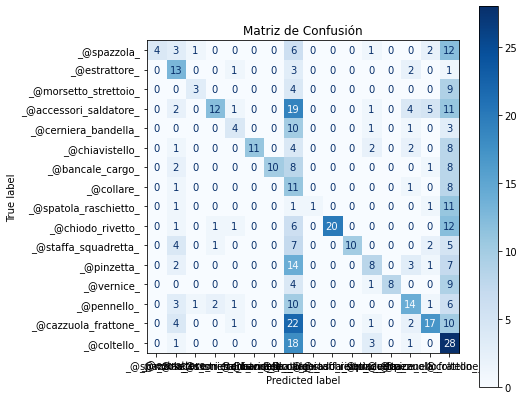

In [213]:
# Matriz de confusion
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [214]:
f1_score(y_val,y_pred,average='macro')

0.3762991865684633

### -Solo Numericas

In [215]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train_number,y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

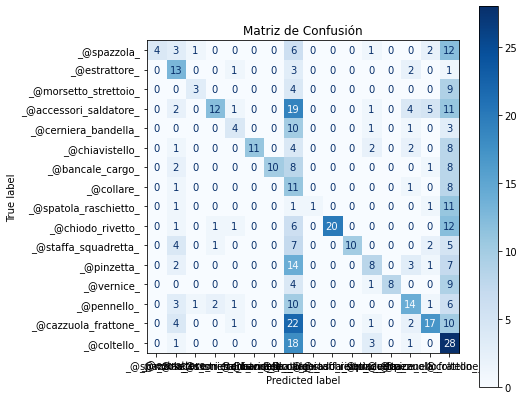

In [216]:
# Matriz de confusion
cm=confusion_matrix(y_val,y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(df_train['class'])))
disp.plot(cmap=plt.cm.Blues,ax=ax)
ax.set_title('Matriz de Confusión')
ax.grid(False) 
plt.show()

In [217]:
f1_score(y_val,y_pred,average='macro')

0.3762991865684633

## -Cross-Validation

Considerando que el modelo Logistico es el que brindo mejores resulados, haremos una validacion cruzada comparando el entrenamiento de dicho modelo tanto con variables de texto asi como numericas.

In [218]:
X=np.array(df_train.drop(['class','title','description','image','word_count_title','word_count_description'],axis=1))
y=df_train['class'].ravel()

In [219]:
kf = KFold(n_splits=32)
kf.get_n_splits(X)
l_ambostxt=list()
l_mixtotal=list()
l_solotitle=list()
l_solodescrip=list()
l_solonum=list()

KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    X_train_number=X_train[:,0:256]
    X_val_number=X_val[:,0:256]
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train[:,256])
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf_T = tfidf_transformer.fit_transform(X_train_counts).toarray()
    X_val_counts = count_vect.transform(X_val[:,256])
    X_val_tfidf_T = tfidf_transformer.transform(X_val_counts).toarray()
    X_train_counts = count_vect.fit_transform(X_train[:,257])
    X_train_tfidf_D = tfidf_transformer.fit_transform(X_train_counts).toarray()
    X_val_counts = count_vect.transform(X_val[:,257])
    X_val_tfidf_D = tfidf_transformer.transform(X_val_counts).toarray()
    X_train_final=np.concatenate((X_train_tfidf_D,X_train_tfidf_T),axis=1)
    X_val_final=np.concatenate((X_val_tfidf_D,X_val_tfidf_T),axis=1)
    logistic_reg = LogisticRegression(solver='liblinear')
    logistic_reg.fit(X_train_final,y_train)
    y_pred=logistic_reg.predict(X_val_final)
    l_ambostxt.append(f1_score(y_val,y_pred,average='macro'))
    X_train_final=np.concatenate((X_train_tfidf_D,X_train_tfidf_T,X_train_number),axis=1)
    X_val_final=np.concatenate((X_val_tfidf_D,X_val_tfidf_T,X_val_number),axis=1)
    logistic_reg = LogisticRegression(solver='liblinear')
    logistic_reg.fit(X_train_final,y_train)
    y_pred=logistic_reg.predict(X_val_final)
    l_mixtotal.append(f1_score(y_val,y_pred,average='macro'))
    logistic_reg = LogisticRegression(solver='liblinear')
    logistic_reg.fit(X_train_tfidf_T,y_train)
    y_pred=logistic_reg.predict(X_val_tfidf_T)
    l_solotitle.append(f1_score(y_val,y_pred,average='macro'))
    logistic_reg = LogisticRegression(solver='liblinear')
    logistic_reg.fit(X_train_tfidf_D,y_train)
    y_pred=logistic_reg.predict(X_val_tfidf_D)
    l_solodescrip.append(f1_score(y_val,y_pred,average='macro'))
    logistic_reg = LogisticRegression(solver='liblinear')
    logistic_reg.fit(X_train_number,y_train)
    y_pred=logistic_reg.predict(X_val_number)
    l_solonum.append(f1_score(y_val,y_pred,average='macro'))

### -Resultados ambos textos

In [220]:
np.array(l_ambostxt).mean()

0.935813051016805

In [221]:
np.array(l_ambostxt).std()

0.04553200777446153

### -Resultados ambos textos mas variables numericas

In [222]:
np.array(l_mixtotal).mean()

0.9156972693092771

In [223]:
np.array(l_mixtotal).std()

0.04612852615718132

### -Resultados solo con titulo

In [224]:
np.array(l_solotitle).mean()

0.9208219335349584

In [225]:
np.array(l_solotitle).std()

0.05245320878144458

### -Resultados solo con descripcion

In [226]:
np.array(l_solodescrip).mean()

0.8767832938174457

In [227]:
np.array(l_solodescrip).std()

0.045731207142726334

### -Resultados solo con variables numericas

In [228]:
np.array(l_solonum).mean()

0.7517837355177135

In [229]:
np.array(l_solonum).std()

0.0512691980730022

De esta manera se concluye que el mejor clasificador se obtiene al entrenar con las columnas titul+descripcion

# -Prosesamiento para el submition Obtenido

Ejecutar las celdas a continacion para replicar los resultados obtenidos en Kaggle

In [230]:
df_train = pd.read_csv("ferramenta_competition_train.csv")
df_test = pd.read_csv("ferramenta_competition_test_without_labels.csv")

In [231]:
df_train['word_count_title'] = df_train['title'].apply(lambda x: len(str(x).split()))
df_train['word_count_description'] = df_train['description'].apply(lambda x: len(str(x).split()))

In [232]:
df_train['clean_title'] = df_train['title'].apply(lambda x: finalpreprocess(x))
df_train['clean_description'] = df_train['description'].apply(lambda x: finalpreprocess(x))

In [233]:
df_test['clean_title'] = df_test['title'].apply(lambda x: finalpreprocess(x))
df_test['clean_description'] = df_test['description'].apply(lambda x: finalpreprocess(x))
df_test=df_test.drop(['title','description'],axis=1)

In [234]:
X=df_train.drop(['class','title','description','image'],axis=1)
y=df_train["class"].ravel()

In [235]:
X_train_number=X.drop(['clean_title','clean_description','word_count_title','word_count_description'],axis=1)
df_test_number=df_test.drop(['clean_title','clean_description','image'],axis=1)

In [236]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X['clean_title'])

In [237]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf_T = tfidf_transformer.fit_transform(X_train_counts).toarray()

In [238]:
X_test_counts = count_vect.transform(df_test['clean_title'])
X_test_tfidf_T = tfidf_transformer.transform(X_test_counts).toarray()

In [239]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X['clean_description'])

In [240]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf_D = tfidf_transformer.fit_transform(X_train_counts).toarray()

In [241]:
X_test_counts = count_vect.transform(df_test['clean_description'])
X_test_tfidf_D = tfidf_transformer.transform(X_test_counts).toarray()

In [242]:
X_train_final=np.concatenate((X_train_tfidf_D,X_train_tfidf_T),axis=1)

In [243]:
X_test_final=np.concatenate((X_test_tfidf_D,X_test_tfidf_T),axis=1)

In [244]:
#pca = PCA(n_components=180)
#pca.fit(X_train_number)

In [245]:
#X_train_number_pca=pca.transform(X_train_number)
#df_test_number_pca=pca.transform(df_test_number)

In [246]:
#X_train_final=np.concatenate((X_train_tfidf_D,X_train_tfidf_T,X_train_number_pca),axis=1)

In [247]:
#X_test_final=np.concatenate((X_test_tfidf_D,X_test_tfidf_T,df_test_number_pca),axis=1)

 -Usaremos el modelo Logistico para el Kaggle ya que mostró ser el de mejor rendimiento.

In [248]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_final, y)

LogisticRegression()

In [249]:
y_pred=logistic_reg.predict(X_test_final)

In [252]:
sample_submission=pd.read_csv("sample_submission.csv")

In [253]:
sample_submission['class']=y_pred

In [254]:
sample_submission.set_index('image',inplace = True)

In [255]:
sample_submission

,class
image,
193298868.jpg,_@morsetto_strettoio_
180043630.jpg,_@morsetto_strettoio_
180043573.jpg,_@morsetto_strettoio_
199501868.jpg,_@bancale_cargo_
147033432.jpg,_@pennello_
...,...
122917523.jpg,_@pinzetta_
190727967.jpg,_@staffa_squadretta_
192891248.jpg,_@vernice_


In [256]:
sample_submission.to_csv('sample_submission_final.csv')